In [16]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.utils as vutils

import os
import sys
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


sys.path.append("../../datasets")
from maskdata import MaskedPokemonDataset

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [17]:
### Hyperparameters

dataroot = "../../data"
workers = 2
batch_size = 128

image_size = 96

val_ratio = 0.2

# Number of color cahnnels in image
nc = 1

# Size of latent vector (encoder will output mus and sigmas of this size)
nz = 16

# Size of feature maps in encoder
nef = 16     # 64 in GAN

# Size of feature maps in decoder
ndf = 16     # 64 in GAN

## training parameters

num_epochs = 1000
# learning rate
lr = 0.0003
beta1 = 0.5

ngpu = 1


### Some notes about architectures, criterions, layers
- Most VAE tutorials use BCELoss + sigmoid output activation functions
    - This also necessitates no normalization in the input transformations
- This is fine when working with MNIST, but seems to not be the correct choice for encoding generalized images
- The combination of your Loss + Activation means something about how you assume your data is distributed
- BCE + Sigmoid Output -> Bernoulli Assumption
- MSE + Identity Output -> Gaussian Assumption
- Softmax + Cross Entropy -> Categorical Assumption

#### Possible Improvements:
- Try MSE + Identity outputs
- Try equipping model with a color reconstruction layer (similar to the GAN I tried)

In [18]:
data_path = "../../data"
csv = "../../data/masks.csv"

transform = transforms.Compose([transforms.ToTensor(), 
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

# Load data
dataset = MaskedPokemonDataset(csv_file=csv, root_dir=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                        shuffle=True, num_workers=workers)

# train test split
# dataset_size = len(dataset)
# idxs = list(range(dataset_size))
# split = int(np.floor(val_ratio * dataset_size))
# np.random.seed(manualSeed)
# np.random.shuffle(idxs)
# train_idxs, val_idxs = idxs[split:], idxs[:split]

# train_sampler = SubsetRandomSampler(train_idxs)
# val_sampler = SubsetRandomSampler(val_idxs)

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
#                                            sampler=train_sampler, num_workers=workers)
                                           

# val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                          sampler=val_sampler, num_workers=workers)

# create dataloaders

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

torch.Size([128, 1, 96, 96])


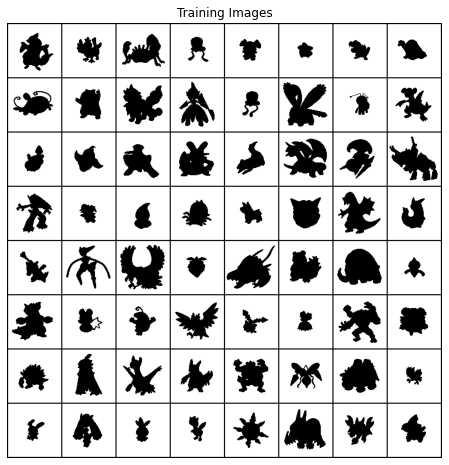

In [19]:
# plot some training images
im_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(im_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

print(im_batch[0].size())


In [20]:
torch.min(im_batch[0][0])

tensor(0.)

### Convolutional VAE architecture

Encoder --> FC Hidden Dimension --> Mu, Sigma --> FC Hidden Dimension --> Decoder

In [21]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            # input: (nc) x 96 x 96
            nn.Conv2d(nc, nef, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: (nef) x 48 x 48
            nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: (nef * 2) x 24 x 24
            nn.Conv2d(nef * 2, nef * 4, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: (nef * 4) x 12 x 12
            nn.Conv2d(nef * 4, nef * 8, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: (nef * 8) x 6 x 6
            nn.Conv2d(nef * 8, nef * 16, 6, 1, 0, bias=False),
            nn.ReLU(inplace=True),
            # state size: (nef * 16) x 1 x 1

        )

    def forward(self, input):
        return self.model(input)


class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            # input: (ndf * 16) x 1 x 1
            nn.ConvTranspose2d(ndf * 16, ndf * 8, 6, 1, 0, bias=False),
            nn.ReLU(inplace=True),
            # state size: (ndf * 8) x 6 x 6
            nn.ConvTranspose2d(ndf * 8, ndf * 4, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: (ndf * 4) x 12 x 12
            nn.ConvTranspose2d(ndf * 4, ndf * 2, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: (ndf * 2) x 24 x 24
            nn.ConvTranspose2d(ndf * 2, ndf, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: (ndf) x 48 x 48
            nn.ConvTranspose2d(ndf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size: (nc) x 96 x 96

            # NOTE: Keras VAE tutorial does not apply the last sigmoid when training,
            # only when decoding
        )

    def forward(self, input):
        return self.model(input)
    

In [22]:
class CVAE(nn.Module):

    def __init__(self):
        super(CVAE, self).__init__()
        # image -> bottleneck
        self.encoder = Encoder()
        # bottleneck -> image
        self.decoder = Decoder()
        
        # go from reparameterized vector to decoder input
        self.from_latent = nn.Linear(nz, ndf*16)

        # Used to get mean and log(std) of input vector
        self.get_mu = nn.Linear(nef*16, nz)
        self.get_logvar = nn.Linear(nef*16, nz)


    def forward(self, input):
        b, _, _, _ = input.shape

        # Encode image
        x = self.encoder(input)
        
        # Bottleneck
        x = x.reshape(b, -1)

        # get mean, log variance
        mu = self.get_mu(x)
        logvar = self.get_logvar(x)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)
        
        # Unbottleneck
        x = self.from_latent(z)
        x = x.view(-1, ndf * 16, 1, 1)

        # Decode image
        reconstruction = self.decoder(x)
        
        return reconstruction, mu, logvar
    

    def reparameterize(self, mu, log_sigma):
        # exponentiate log(variance)
        # This is done to ensure positive values for sigma
        sigma = torch.exp(0.5 * log_sigma)
        
        # trick is to get epsilon in N(0, 1) and use mu + epsilon * sigma
        # this samples our latent distribution
        eps = torch.randn_like(sigma)

        return mu + (eps * sigma)
    
    @torch.no_grad()
    def sample(self, eps=None, total_samples=100):
        if eps is None:
            eps = torch.randn(total_samples, nz)
        z = self.from_latent(eps).view(-1, ndf * 16, 1, 1)
        return self.decoder(z)

In [23]:
# Initialize model
vae = CVAE().to(device)
print(vae)


CVAE(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): ReLU(inplace=True)
      (8): Conv2d(128, 256, kernel_size=(6, 6), stride=(1, 1), bias=False)
      (9): ReLU(inplace=True)
    )
  )
  (decoder): Decoder(
    (model): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(6, 6), stride=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): ReLU(inplace=True)
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 

In [24]:
# # test dimensions

# input = torch.randn(4, nc, image_size, image_size).to(device)
# print(f"In size: {input.size()}")

# with torch.no_grad(): # can also act as a function decorator
#     output = vae(input)

# print(f"Out size: {output[0].size()}")

In [25]:
def elbo_loss(recon_loss, mu, logvar):
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp() )
    return recon_loss + kl_loss

In [26]:
# Initialize binary cross entropy loss
criterion = nn.BCELoss(reduction='sum')

# beta2 should be 0.999 for sparse gradient tasks (NLP, CV)
# optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(beta1, 0.999)) 
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Create fixed noise batch to see how sampling improves over training
fixed_noise = torch.randn(64, nz, device=device)

### Training Loop

In [27]:
# Training Loop

# Lists for progress tracking
img_list = []
losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in training data
    for i, data in enumerate(dataloader, 0):
        # format batch
        im_batch = data[0].to(device)
        # get reconstructed images
        outputs, mu, logvar = vae(im_batch)
        # calculate reconstruction loss
        recon_loss = criterion(outputs, im_batch)
        errVAE = elbo_loss(recon_loss, mu, logvar)
        
        vae.zero_grad()
        errVAE.backward()
        optimizer.step()

        # Bookkeeping and printing out loss
        losses.append(errVAE.item())

        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_recon: %.4f\tLoss_elbo: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     recon_loss.item(), errVAE.item()))

        # Check how latent space is doing using output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = vae.sample(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1

        

Starting Training Loop...
[0/1000][0/22]	Loss_recon: 817646.6250	Loss_elbo: 817649.0625
[0/1000][10/22]	Loss_recon: 808431.1250	Loss_elbo: 808644.5625
[0/1000][20/22]	Loss_recon: 536286.5000	Loss_elbo: 550864.9375
[1/1000][0/22]	Loss_recon: 488262.9688	Loss_elbo: 496360.2188
[1/1000][10/22]	Loss_recon: 380075.7500	Loss_elbo: 382689.0938
[1/1000][20/22]	Loss_recon: 344677.0000	Loss_elbo: 347079.0625
[2/1000][0/22]	Loss_recon: 353120.3750	Loss_elbo: 355368.1250
[2/1000][10/22]	Loss_recon: 292998.0000	Loss_elbo: 296057.3750
[2/1000][20/22]	Loss_recon: 312933.2500	Loss_elbo: 315365.6562
[3/1000][0/22]	Loss_recon: 312872.9375	Loss_elbo: 317255.7812
[3/1000][10/22]	Loss_recon: 307837.8438	Loss_elbo: 310755.4375
[3/1000][20/22]	Loss_recon: 306713.6250	Loss_elbo: 312128.6562
[4/1000][0/22]	Loss_recon: 282175.1875	Loss_elbo: 288671.0000
[4/1000][10/22]	Loss_recon: 293640.1875	Loss_elbo: 298981.6562
[4/1000][20/22]	Loss_recon: 321536.9375	Loss_elbo: 326225.4688
[5/1000][0/22]	Loss_recon: 295867.

KeyboardInterrupt: 

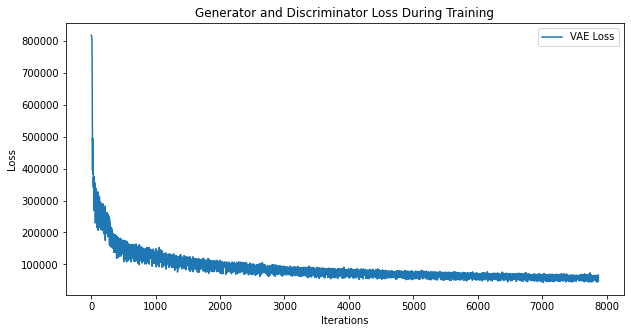

In [28]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses,label="VAE Loss")
# plt.plot(val_losses,label="Val")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

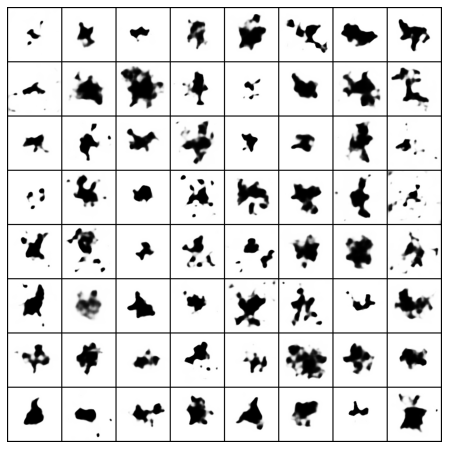

In [29]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

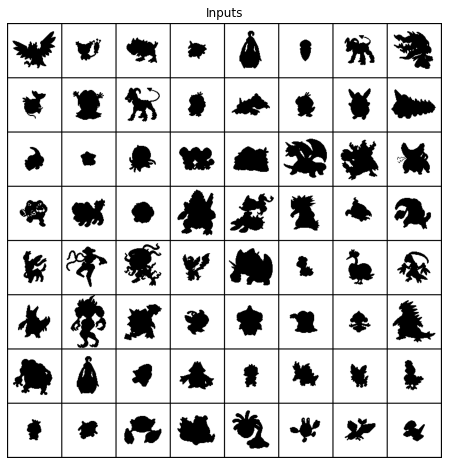

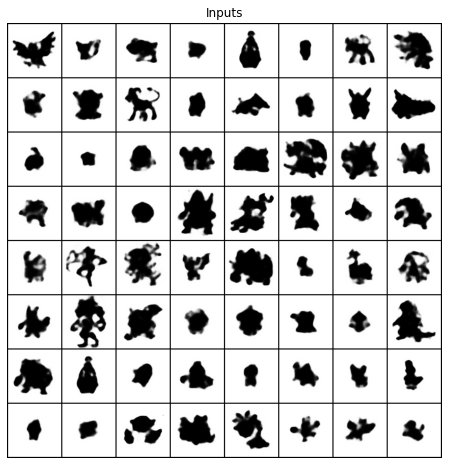

In [30]:
# generate some versions of one pokemon:
poke_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Inputs")
plt.imshow(np.transpose(vutils.make_grid(poke_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

with torch.no_grad():
    reconstructions, mus, sigmas = vae(poke_batch[0].to(device))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Inputs")
plt.imshow(np.transpose(vutils.make_grid(reconstructions[:64], padding=2, normalize=True).cpu(),(1,2,0)))



In [109]:
# try interpolation!
from PIL import Image

base = "../../"
sys.path.append(base)

p1_path = base + "data/masks/3_default_front_default_mask.png"
p2_path = base + "data/masks/376_default_front_default_mask.png"

p1 = Image.open(p1_path)
p2 = Image.open(p2_path)

transform = transforms.ToTensor()

p1 = transform(p1).view(1, 1, 96, 96).to(device)
p2 = transform(p2).view(1, 1, 96, 96).to(device)

# Encode representations of the two pokemon
with torch.no_grad():
    _, p1_mu, p1_logvar = vae(p1)
    _, p2_mu, p2_logvar = vae(p2)


In [110]:
# interpolation step
p1_sigma, p2_sigma = torch.exp(0.5 * p1_logvar), torch.exp(0.5 * p2_logvar)

p1 = p1_mu + torch.randn_like(p1_mu) * p1_sigma
p2 = p2_mu + torch.randn_like(p2_mu) * p2_sigma

num_steps = 10
alpha = 1 / num_steps

def z_to_image(z):
    recon = vae.sample(eps=z, total_samples=1).view(1, 96, 96).cpu()
    return transforms.ToPILImage()(recon)
    
im_list = [z_to_image(p1)]

interpolated_ims = []

for i in range(1, num_steps):
    alpha_step = alpha * i
    mid_p = p1 * (1 - alpha_step) + p2 * alpha_step 
    im_list.append(z_to_image(mid_p))

im_list.append(z_to_image(p2))

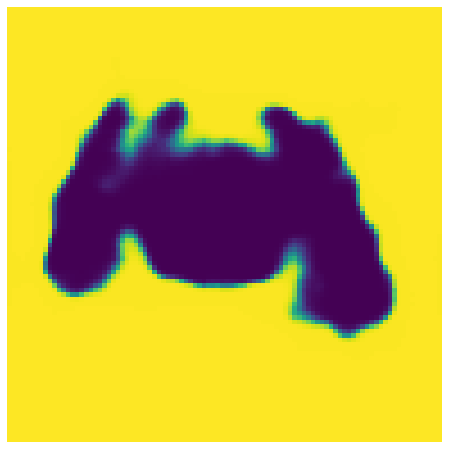

In [111]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in im_list]
ani = animation.ArtistAnimation(fig, ims, interval=400, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [69]:
for i in im_list:
    i.show()